In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
import alphalens as al
%matplotlib inline

In [3]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu'] #, 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd']#, 'AP', 'sp']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts


In [4]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2016,1,1)
end_date = datetime.date(2020,6,13)

product_list = ['rb', 'hc', 'i', 'j'] #['cu', 'al', 'zn', 'pb', 'ni', 'sn']
need_shift = 2
freq = 'm'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-20b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

df_list = []
for idx, asset in enumerate(product_list):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb']:
        use_args = base_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(backtest.sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [(asset, col) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False).fillna(method = 'ffill').dropna()

loading mkt = rb, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 2, 'start_date': datetime.date(2016, 1, 1), 'end_date': datetime.date(2020, 6, 13)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 2, 'start_date': datetime.date(2016, 1, 1), 'end_date': datetime.date(2020, 6, 13)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 2, 'start_date': datetime.date(2016, 1, 1), 'end_date': datetime.date(2020, 6, 13)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'm', 'need_shift': 2, 'start_date': datetime.date(2016, 1, 1), 'end_date': datetime.date(2020, 6, 13)}


In [6]:
xdf = dh.conv_ohlc_freq1(df, '14m')
#xdf = df.copy()
#xdf = dh.day_split1(xdf, [300, 352, 450, 1500, 1528, 1630, 1655, 1724, 1930, 1949, 2018, 2047, 2100])

#xdf = dh.day_split1(xdf, [300, 1500, 1930, 2115])
xdf.index = pd.to_datetime(xdf.index)
xdf.index.names = [('common', 'datetime')]
xdf.rename(columns = {'date': ('common', 'date'), 'min_id': ('common', 'min_id')}, inplace = True)
xdf.columns = pd.MultiIndex.from_tuples(xdf.columns, names = ['asset', 'feild'])
xdf['start_min'] = xdf.index.to_series().apply(lambda x: misc.get_min_id(x))
win = 30
ma_win = 12
std_win = 120
factor_name = 'ret_fact'
price_field = 'close'
pos_std = False
for asset in product_list:
    if need_shift == 1:
        xdf[(asset, 'lr')] = ((xdf[(asset, price_field)]- xdf[(asset, 'shift')]).astype('float')\
                                /(xdf[(asset, price_field)].shift(1) - xdf[(asset, 'shift')]) - 1.0) * 100.0
    else:
        xdf[(asset, 'lr')] = (xdf[(asset, price_field)].astype('float')\
                              / xdf[(asset, price_field)].shift(1) - 1.0) * 100.0
    xdf[(asset, factor_name)] = xdf[(asset, 'lr')].rolling(win).sum().rolling(ma_win).mean()
    if pos_std:
        xdf[(asset, 'std')] = xdf[(asset, 'lr')].rolling(std_win).std()
    else:
        xdf[(asset, 'std')] = 1.0


In [7]:
fac_df = xdf[[(asset, factor_name) for asset in product_list]]
fac_df.columns = product_list
fac_ts = fac_df.stack()
fac_ts.name = factor_name

pricing_data = xdf[[(asset, price_field) for asset in product_list]].astype('float')
pricing_data.columns = product_list
res = al.utils.compute_forward_returns(fac_ts, pricing_data)
print(res)

                                14m     1h10m    10h16m
date                asset                              
2016-01-05 10:06:00 rb     0.000000 -0.001684  0.000000
                    hc    -0.000513  0.000000  0.001539
                    i      0.000000  0.006202  0.006202
                    j      0.001567  0.003135  0.002351
2016-01-05 10:30:00 rb    -0.001684 -0.000561  0.000000
...                             ...       ...       ...
2020-06-12 14:32:00 j      0.001271       NaN       NaN
2020-06-12 14:46:00 rb          NaN       NaN       NaN
                    hc          NaN       NaN       NaN
                    i           NaN       NaN       NaN
                    j           NaN       NaN       NaN

[119640 rows x 3 columns]


In [ ]:
factor_data = al.utils.get_clean_factor(fac_ts, res, quantiles=10, bins=None,
                                binning_by_group=False, max_loss=0.35, zero_aware=False)
#factor_data = al.utils.get_clean_factor_and_forward_returns(fac_ts, pricing_data, quantiles=10, periods=(1,5,10))
print(factor_data.head())

#al.tears.create_information_tear_sheet(factor_data)
#al.tears.create_full_tear_sheet(factor_data)

#al.tears.create_returns_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)


In [ ]:
rank_dict = {}
rng_dict = {}
adf_dict[factor_name] = xdf[[(asset, factor_name) for asset in product_list]]
rank_dict[factor_name] = adf_dict[factor_name].rank(axis=1)
rng_dict[factor_name] = adf_dict[factor_name].max(axis=1) - adf_dict[factor_name].min(axis=1)

                     rebal_seqno  start_min  rebal_flag
datetime                                               
2020-04-10 10:48:00        31098       1648           1
2020-04-10 11:02:00        31099       1702           1
2020-04-10 11:16:00        31100       1716           1
2020-04-10 13:30:00        31101       1930           1
2020-04-10 13:36:00        31102       1936           1
2020-04-10 13:50:00        31103       1950           1
2020-04-10 14:04:00        31104       2004           1
2020-04-10 14:18:00        31105       2018           1
2020-04-10 14:32:00        31106       2032           1
2020-04-10 14:46:00        31107       2046           1
date
2020-02-28    2707279.375
2020-03-02    2704952.000
2020-03-03    2699564.875
2020-03-04    2719832.875
2020-03-05    2734786.250
2020-03-06    2720335.250
2020-03-09    2707793.375
2020-03-10    2668257.750
2020-03-11    2651631.125
2020-03-12    2646829.875
2020-03-13    2639376.750
2020-03-16    2641240.000
2020-03-17 

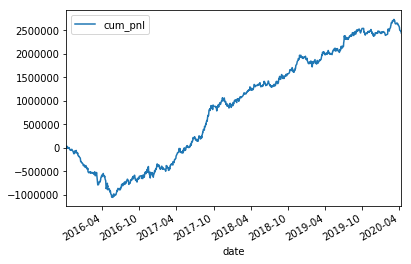

                               0
avg_pnl_1y          1.839172e+03
avg_pnl_2y          2.459805e+03
avg_pnl_3y          3.474296e+03
avg_pnl_4y          3.101940e+03
max_dd_period_1y   -3.600000e+01
max_dd_period_2y   -3.600000e+01
max_dd_period_3y   -3.600000e+01
max_dd_period_4y   -4.000000e+01
max_drawdown_1y    -2.874335e+05
max_drawdown_2y    -2.874335e+05
max_drawdown_3y    -2.874335e+05
max_drawdown_4y    -4.524224e+05
num_days_1y         2.450000e+02
num_days_2y         4.890000e+02
num_days_3y         7.340000e+02
num_days_4y         9.760000e+02
profit_dd_ratio_1y  1.567657e+00
profit_dd_ratio_2y  4.184776e+00
profit_dd_ratio_3y  8.872082e+00
profit_dd_ratio_4y  6.691740e+00
sharp_ratio_1y      1.263520e+00
sharp_ratio_2y      1.664849e+00
sharp_ratio_3y      2.233289e+00
sharp_ratio_4y      1.847577e+00
std_pnl_1y          2.310684e+04
std_pnl_2y          2.345450e+04
std_pnl_3y          2.469574e+04
std_pnl_4y          2.665207e+04
tot_cost_1y         1.493738e+05
tot_cost_2

In [83]:
total_risk = 1600000.0
rebal_freq = 3
margin_rate = [0.08, 0.08]
pnl_tenors = ['1y', '2y', '3y', '4y']
cost_ratio = 1.0
#offset_list = [0.0, 0.0, 0.0, 0.0, 0.0]
offset_list = [1.0, 0.5, 0.5]
offset_list = [x * 0.25 for x in offset_list]
start_capital = 0.0

quantile_cutoff = 0.20
kcut = int(quantile_cutoff * len(product_list) + 0.5)
upper_rank = len(product_list) - kcut
lower_rank = 1 + kcut
xdf['rebal_flag'] = 1
#print rng_dict['lr0'][-10:]
#flag = (xdf['start_min'].isin([])) | (rng_dict['lr0'] < 0.0)
#xdf.loc[flag, 'rebal_flag'] = 0

xdf['rebal_seqno'] = xdf['rebal_flag'].cumsum()
print xdf[['rebal_seqno', 'start_min', 'rebal_flag']][-10:]
#xdf['rebal_seqno'] = range(len(xdf.index))

sum_rank = pd.DataFrame(columns=product_list, index = xdf.index)
for asset in product_list:
    sum_rank[asset] = rank_dict['lr0'][(asset, 'lr0')]
    for col in ['lr%s'%(idx+1) for idx in range(len(win_list)-1)]:
        sum_rank[asset] = sum_rank[asset] + rank_dict[col][(asset, col)]

sum_rank = sum_rank.rank(axis=1, method='first')
long_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)
short_pos = pd.DataFrame(0, columns=product_list, index = xdf.index)

for rebal_idx in range(rebal_freq):
    long_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
    short_tmp = pd.DataFrame(columns=product_list, index = xdf.index)
    rebal_flag = xdf['rebal_seqno'].apply(lambda x: (x % rebal_freq) == rebal_idx) & (xdf['rebal_flag'] == 1)
    for asset in product_list:
        long_tmp.loc[(sum_rank[asset] > upper_rank) & rebal_flag, asset] = 1.0
        long_tmp.loc[(sum_rank[asset] <= upper_rank) & rebal_flag, asset] = 0.0
        short_tmp.loc[(sum_rank[asset] < lower_rank) & rebal_flag, asset] = 1.0
        short_tmp.loc[(sum_rank[asset] >= lower_rank) & rebal_flag, asset] = 0.0
    long_tmp = long_tmp.fillna(method='ffill').fillna(0)
    short_tmp = short_tmp.fillna(method='ffill').fillna(0)
    #long_sum = long_tmp.sum(axis=1)
    #short_sum = short_tmp.sum(axis=1)
    long_pos = long_pos + long_tmp #.div(long_sum,axis=0)
    short_pos = short_pos + short_tmp #.div(short_sum,axis=0)

net_pos = long_pos - short_pos

pos_nchg = (net_pos == net_pos.shift(1))
net_pos[pos_nchg] = np.nan

extract_fields = ['open', 'close', 'traded_price', 'contract', 'cost', 'pos']
df_list = []

for asset, offset in zip(product_list, offset_list):
    #long_pos[asset] = (long_pos[asset] * total_risk/xdf[(asset,'close')].astype('float')).shift(1).fillna(method='ffill') # 
    #short_pos[asset] = (short_pos[asset] * total_risk/xdf[(asset,'close')].astype('float')).shift(1).fillna(method='ffill') # 
    if need_shift == 1:
        orig_close = xdf[(asset, 'close')] - xdf[(asset, 'shift')]
    elif need_shift == 2:
        orig_close = xdf[(asset, 'close')] * np.exp(-xdf[(asset, 'shift')])
    else:
        orig_close = xdf[(asset, 'close')]
    net_pos[asset] = (net_pos[asset] * total_risk / (rebal_freq * orig_close * xdf[(asset, 'std')])).astype('float').shift(1).fillna(method='ffill').fillna(0.0).astype('int')
    #long_pos[asset] = (long_pos[asset] * self.total_risk / xdf[(asset, 'close')].astype('float')).astype('int').shift(1).fillna(method='ffill')
    #short_pos[asset] = (short_pos[asset] * self.total_risk / xdf[(asset, 'close')].astype('float')).astype('int').shift(1).fillna(method='ffill')
    xdf[(asset, 'pos')] = net_pos[asset]
    #xdf[(asset, 'pos')] = long_pos[asset] - short_pos[asset]
    xdf[(asset, 'traded_price')] = xdf[(asset, 'open')]
    xdf.ix[-1, (asset, 'pos')] = 0
    xdf[(asset, 'cost')] = abs(xdf[(asset, 'pos')] - xdf[(asset, 'pos')].shift(1)) * offset
    xdf[(asset, 'cost')] = xdf[(asset, 'cost')].fillna(0.0)
    fields = [(asset, field) for field in extract_fields]    
    tdf = xdf[fields]
    tdf.columns = extract_fields
    tdf['date'] = xdf['date']
    tdf['min_id'] = xdf['min_id']    
    #closed_trades = backtest.simdf_to_trades1(tdf, slippage = offset)

(res_pnl, ts) = backtest.get_pnl_stats(df_list, margin_rate, 'm', tenors = pnl_tenors, start_capital = start_capital, cost_ratio = cost_ratio)
#print net_pos
print ts['cum_pnl'][-30:]
ts[['cum_pnl']].plot()
plt.show()
pnl_df = pd.DataFrame.from_dict(res_pnl, orient='index').sort_index()
print pnl_df